### Necessary Imports and Installs

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Conv2D, Dense, AveragePooling2D, \
BatchNormalization, Normalization, Dropout, Flatten, Lambda, Input, Activation, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import Callback, LambdaCallback
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
#import tensorflow_datasets as tfds

import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import scale
import time
import random
from collections import defaultdict
import math
import copy
import threading
import opendatasets as od
import tempfile
from sklearn.utils import shuffle

%pylab inline --no-import-all
from pathlib import Path
import pandas as pd
import sys

from GLC.data_loading.common import load_patch

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3qsv0k2j because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Dataset

## Download Dataset

In [2]:
# only uncomment if you don't have the dataset stored on disk yet
# -> have your kaggle user credentials ready
#data = od.download("https://www.kaggle.com/competitions/geolifeclef-2022-lifeclef-2022-fgvc9")

## Load Dataset from file

Set path to competition dataset here.

In [3]:
# Change this path to adapt to where you downloaded the data
DATA_PATH = Path("./geolifeclef-2022-lifeclef-2022-fgvc9/")

Run the following two commands to verify that the data path is set correctly. They should print folder and file names.

In [4]:
ls -L $DATA_PATH

metadata/      patches-fr/  patches_sample/  rasters/
observations/  patches-us/  pre-extracted/   sample_submission.csv


In [5]:
ls $DATA_PATH/observations

observations_fr_test.csv   observations_us_test.csv
observations_fr_train.csv  observations_us_train.csv


Load the observation ids of the training dataset.

In [6]:
### Training Dataset ###
# let's load the data from file
df_obs_fr = pd.read_csv(DATA_PATH / "observations" / "observations_fr_train.csv", sep=";", index_col="observation_id")
df_obs_us = pd.read_csv(DATA_PATH / "observations" / "observations_us_train.csv", sep=";", index_col="observation_id")

df_obs = pd.concat((df_obs_fr, df_obs_us))

print("Number of observations for training: {}".format(len(df_obs)))

# let's have a look at the data
df_obs.head()

Number of observations for training: 1627475


,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train
10392536,48.604866,-2.825003,1456,train
10335049,48.815567,-0.161431,157,train


Load the observation ids of the test dataset.

In [7]:
### Test Dataset ###
df_obs_fr_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";", index_col="observation_id")
df_obs_us_test = pd.read_csv(DATA_PATH / "observations" / "observations_us_test.csv", sep=";", index_col="observation_id")

df_obs_test = pd.concat((df_obs_fr_test, df_obs_us_test))

print("Number of observations for testing: {}".format(len(df_obs_test)))

df_obs_test.head()

Number of observations for testing: 36421


,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459
10222322,46.938450,5.298678
10241950,45.017433,0.960736


Load suggested landcover alignment (only relevant if you're using landcover data later).

In [8]:
df_suggested_landcover_alignment = pd.read_csv(DATA_PATH / "metadata" / "landcover_suggested_alignment.csv", sep=";")
print(df_suggested_landcover_alignment.head())
landcover_mapping = df_suggested_landcover_alignment["suggested_landcover_code"].values

   landcover_code  suggested_landcover_code suggested_landcover_label
0               0                         0              Missing Data
1               1                        11          Cultivated Crops
2               2                        11          Cultivated Crops
3               3                         6       Broad-leaved Forest
4               4                         7         Coniferous Forest


### Train/Val Split Labels
Retrieve the train/val split provided, and load the labels of the train and val set elements.

In [9]:
obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
obs_id_val = df_obs.index[df_obs["subset"] == "val"].values

y_train = df_obs.loc[obs_id_train]["species_id"].values
y_val = df_obs.loc[obs_id_val]["species_id"].values

n_val = len(obs_id_val)
print("Training set size: {} ({:.1%} of train observations)".format(len(y_train), len(y_train) / len(df_obs)))
print("Validation set size: {} ({:.1%} of train observations)".format(n_val, n_val / len(df_obs)))

Training set size: 1587395 (97.5% of train observations)
Validation set size: 40080 (2.5% of train observations)


**Let's have a look at the training dataset.**

In [10]:
print("=== Training Dataset ===")
print("There are {} unique labels.".format(len(np.unique(y_train))))
print("We have {:.2f} observations per label on average.".format(len(obs_id_train)/len(np.unique(y_train))))

=== Training Dataset ===
There are 17031 unique labels.
We have 93.21 observations per label on average.


In [ ]:
# label_count = defaultdict(lambda: 0)

# print("counting observation ids per label ...")
# for ob in df_obs.iterrows():
#     label_count[ob[1]['species_id']] += 1
# print("done")

In [ ]:
# buckets = [0, 10, 100, 500, 1000, 2000, 3000, 10000, 100000]
# buckets_counts = {0: 0, 10: 0, 100: 0, 500: 0, 1000: 0, 2000: 0, 3000: 0, 10000: 0, 100000: 0}
# buckets_labels = {0: list(), 10: list(), 100: list(), 500: list(), 1000: list(), 
#                   2000: list(), 3000: list(), 10000: list(), 100000: list()}

# for label in label_count:
#     c = label_count[label]
    
#     i = 0
#     while c > buckets[i]:
#         i += 1
#     i -= 1
        
#     #print("c: ", c)
#     #print("buckets[i]: ", buckets[i])
    
#     buckets_counts[buckets[i]] += 1
#     buckets_labels[buckets[i]].append(label)
    
# print("=== Analysis of observation ids per label in training set ===")
# print("{:<15}: # of labels that have that range amount of obs ids".format("# of obs ids"))
# print()
# for i in range(0, len(buckets)-1):
#     print("{:<15}: {amount:>4} labels".format("{lower} to {upper}".format(lower=buckets[i], upper=buckets[i+1]), 
#                                               amount=buckets_counts[buckets[i]]))

# #print(buckets_contents)

Now only retrieve the data belonging to a subset of all possible labels.

In [ ]:
# subset_size = 10
# obs_list = list()

# # iterate over a subset of the labels
# counter = 0
# for y in np.unique(y_train)[:subset_size]:
#     # for each label, retrieve all corresponding observation ids
#     obs = df_obs.index[df_obs["species_id"] == y].values
#     obs_list.append(obs)
    
# # we now have a numpy array of all observation ids corresponding to this subset of labels
# obs_id_train = np.concatenate(obs_list)

# # obtain the gps coordinates
# latitudes_train = df_obs.loc[obs_id_train]["latitude"].values
# longitudes_train = df_obs.loc[obs_id_train]["longitude"].values
# gps_train = np.column_stack((latitudes, longitudes))

# # obtain the labels in the right order 
# y_train = df_obs.loc[obs_id_train]["species_id"].values

In [ ]:
# ### JUST TO TEST IF INPUT PIPELINE WORKS ###
# # load training dataset samples
# # factor = 1 means load full training dataset
# # factor = 100 means load 1/100 of the full dataset
# factor = 100

# obs_list = list()
# for obs_id in obs_id_train:
#     obs_list.append(obs_id)
    
#     if len(obs_list) >= (len(y_train)/factor):
#         break
        
# obs_id_train = np.array(obs_list)
# y_train = y_train[:len(obs_id_train)]

# print("obs_id array shape: ", np.shape(obs_id_train))
# print("label array shape: ", np.shape(y_train))
# print(np.min(y_train[:len(obs_id_train)]))
# print(np.max(y_train[:len(obs_id_train)]))

In [ ]:
# ### Keep only the labels with lots of observations ###
# min_obs_count = 2000
# max_obs_count = 3000

# # obtain all relevant labels
# y_train = list()
# for b in buckets:
#     if b >= min_obs_count and b <= max_obs_count:
#         for l in buckets_labels[b]:
#             y_train.append(l)
# print("obtained all relevant labels")
            
# # obtain all corresponding obs ids
# obs_list = list()

# # iterate over a subset of the labels
# counter = 0
# for y in y_train:
#     # for each label, retrieve all corresponding observation ids
#     obs = df_obs.index[(df_obs["subset"] == "train") & (df_obs["species_id"] == y)].values
#     #print(len(obs))
#     obs_list.append(obs)
    
# # we now have a numpy array of all observation ids corresponding to this subset of labels
# obs_id_train_new = np.concatenate(obs_list)
# print("obtained all observations")

# # obtain the labels in the right order 
# y_train = df_obs.loc[obs_id_train_new]["species_id"].values

# print(len(obs_id_train_new))
# print(len(obs_id_train))

# # count how many ids exist in obs_id_train_new that don't exist in obs_id_train
# # should be 0
# print("should be 0: ", len(obs_id_train_new) - len(obs_id_train_new[np.in1d(obs_id_train_new, obs_id_train)]))

# print(len(np.unique(y_train)))
# print(np.unique(y_train))

# obs_id_train = obs_id_train_new

In [11]:
### Kennedy's Train, Val and Test Split ###
# CHOOSE SUBSET FOR 30 Labels
label_amount = 30

import random
subset_size = 0
obs_list = list()
obs_test_list = list()
import numpy as np
# iterate over a subset of the labels
m = 0
for y in (np.unique(y_train)[:]):
    #print("in")
    # for each label, retrieve all corresponding observation ids
    obs = df_obs.index[(df_obs["species_id"] == y)]
   
    #print(len(obs))
    #print(counter)
    #print(obs)
    #print(len(obs))
    if (len(obs) >= 2000 and len(obs) <= 3000):
      t = set(df_obs.index[(df_obs["species_id"] == y) & (df_obs["subset"] == "train")].values)
      m += len(t)
      ten_perc = int(len(t)/10)
      random.seed(3)
      test = random.sample(t, ten_perc)
      train = t-set(test)
      #print(train)
      #print("here")
      obs_test_list.append(list(test))
      obs_list.append(list(train))
      subset_size += 1
    if (subset_size >= label_amount):
      #print("break")
      break
print(m)   
# we now have a numpy array of all observation ids corresponding to this subset of labels
obs_id_train = np.concatenate(obs_list)
obs_id_test = np.concatenate(obs_test_list)
gps_train = np.concatenate((df_obs.loc[obs_id_train]["latitude"].values, df_obs.loc[obs_id_train]["longitude"].values))
# obtain the labels in the right order 
y_train = df_obs.loc[obs_id_train]["species_id"].values
y_test = df_obs.loc[obs_id_test]["species_id"].values
print(y_train.size)

print()
print(y_test.size)
print(y_train[2])
print()

70294
63278

7016
5



In [12]:
#subset_size = 8
obs_list_1 = list()
print(y_val.size)

# iterate over a subset of the labels
counter = 0
print(y_val[0])
for y in (np.unique(y_val)[:]):
    # for each label, retrieve all corresponding observation ids
    if (y in y_train):
      #obs = df_obs.index[df_obs["species_id"] == y].values
      v = df_obs.index[(df_obs["species_id"] == y) & (df_obs["subset"] == "val")].values
      obs_list_1.append(v)
# we now have a numpy array of all observation ids corresponding to this subset of labels
obs_id_val = np.concatenate(obs_list_1)

# obtain the labels in the right order 
y_val = df_obs.loc[obs_id_val]["species_id"].values
gps_val = np.concatenate((df_obs.loc[obs_id_val]["latitude"].values, df_obs.loc[obs_id_val]["longitude"].values))

print(y_val.size)
print(obs_id_val == obs_id_train)

40080
11
1831
False


<ipython-input-12-687b69893308>:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(obs_id_val == obs_id_train)


In [13]:
train_dict_count = defaultdict(lambda: 0)
for y in y_train:
    train_dict_count[y] += 1
    
print("training: ")
for key, value in train_dict_count.items():
    print("label {:>4}: {:.2f}%".format(key, value/len(y_train)))

print()

val_dict_count = defaultdict(lambda: 0)
for y in y_val:
    val_dict_count[y] += 1
    
print("validation: ")
for key, value in val_dict_count.items():
    print("label {:>4}: {:.2f}%".format(key, value/len(y_val)))

training: 
label    5: 0.04%
label   68: 0.03%
label  125: 0.04%
label  129: 0.03%
label  223: 0.03%
label  553: 0.03%
label  570: 0.03%
label  605: 0.03%
label  679: 0.03%
label  692: 0.03%
label  739: 0.03%
label  979: 0.04%
label 1075: 0.04%
label 1155: 0.03%
label 1916: 0.03%
label 2196: 0.03%
label 2524: 0.04%
label 2821: 0.03%
label 2950: 0.03%
label 2992: 0.03%
label 3253: 0.03%
label 4940: 0.04%
label 4991: 0.04%
label 4999: 0.04%
label 5025: 0.03%
label 5086: 0.03%
label 5168: 0.03%
label 5192: 0.03%
label 5207: 0.04%
label 5228: 0.04%

validation: 
label    5: 0.03%
label   68: 0.03%
label  125: 0.02%
label  129: 0.03%
label  223: 0.03%
label  553: 0.03%
label  570: 0.03%
label  605: 0.03%
label  679: 0.02%
label  692: 0.04%
label  739: 0.03%
label  979: 0.03%
label 1075: 0.03%
label 1155: 0.03%
label 1916: 0.03%
label 2196: 0.03%
label 2524: 0.04%
label 2821: 0.04%
label 2950: 0.05%
label 2992: 0.05%
label 3253: 0.03%
label 4940: 0.04%
label 4991: 0.01%
label 4999: 0.04%
lab

In [14]:
np.unique(y_train) == np.unique(y_val)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

### Remap the labels s.t. they go from 0 to n-1
(NAN fix is here)

In [15]:
# create a map s.t. the labels will go from 0 to n-1
map_labels = dict()
i = 0
for l in np.unique(y_train):
    map_labels[l] = i
    i+=1
print(map_labels)

{5: 0, 68: 1, 125: 2, 129: 3, 223: 4, 553: 5, 570: 6, 605: 7, 679: 8, 692: 9, 739: 10, 979: 11, 1075: 12, 1155: 13, 1916: 14, 2196: 15, 2524: 16, 2821: 17, 2950: 18, 2992: 19, 3253: 20, 4940: 21, 4991: 22, 4999: 23, 5025: 24, 5086: 25, 5168: 26, 5192: 27, 5207: 28, 5228: 29}


In [16]:
# apply the map to the training labels
y_train_normalized = np.zeros(np.shape(y_train), dtype='int64')

for i in range(len(y_train)):
    y_train_normalized[i] = map_labels[y_train[i]]
    
# shuffle together
obs_id_train, y_train = shuffle(obs_id_train, y_train_normalized)

no_output_neurons = len(np.unique(y_train))
print("# output neurons: ", no_output_neurons)

# output neurons:  30


In [17]:
# apply the map to the validation labels
y_val_normalized = np.zeros(np.shape(y_val), dtype='int64')

for i in range(len(y_val)):
    y_val_normalized[i] = map_labels[y_val[i]]
    
# shuffle together
obs_id_val, y_val = shuffle(obs_id_val, y_val_normalized)

## Write input pipeline to load batches as we train.

### Custom Generator
Since dataset is too large to load it all into memory once, we need to load it from disk in batches as we train. Such a generator can later be passed into model.fit() instead of a train and/or validation dataset.

In [18]:
class Patches_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, obs_ids, labels, batch_size) :
        self.obs_ids = obs_ids
        self.labels = labels
        self.batch_size = batch_size
        
        # to make the generator thread safe 
        self.lock = threading.Lock()

    def __len__(self) :
        return (np.ceil(len(self.obs_ids) / float(self.batch_size))).astype(int)
  
    # returns one batch
    def __getitem__(self, idx) :
        X_batch = list()
        y_batch = list()

        for i in range(idx * self.batch_size, (idx+1) * self.batch_size):
            if i >= len(self.obs_ids): break
            
            patch = load_patch(self.obs_ids[i], DATA_PATH, data='rgb')
            X_batch.append(patch[0])
            y_batch.append(self.labels[i])

        with self.lock:
            return np.asarray(X_batch), np.array(y_batch)

# First Simple Neural Network
Let's create a first neural network as a baseline to see how it performs.

In [19]:
# # for distributed training (that is, using multiple GPUs for data parallelization)
# # https://www.tensorflow.org/guide/distributed_training#use_tfdistributestrategy_with_keras_modelfit
# mirrored_strategy = tf.distribute.MirroredStrategy()

In [19]:
# returns a 10 layer ReLU model of width 2
def simple_model(input_shape, learning_rate=0.0001, output_neurons=30, seed=42):
    random.seed(seed)
    
    model = tf.keras.models.Sequential()
    
    # 1. Preprocessing
    # rescale inputs
    model.add(tf.keras.layers.Rescaling(1./255))
    #model.add(tf.keras.layers.RandomFlip("horizontal"))
    #model.add(tf.keras.layers.RandomRotation(factor=0.02))
    model.add(tf.keras.layers.RandomContrast(factor=0.1))
    model.add(tf.keras.layers.RandomCrop(input_shape[0], input_shape[1]))

    # 2. Convolutional Layers
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape, padding='same'))
    #model.add(AveragePooling2D())

    model.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
    #model.add(AveragePooling2D())
    
    model.add(Conv2D(128, kernel_size=5, activation='relu', padding='same'))
    
    # from convolutional layers to dense layers
    model.add(tf.keras.layers.Flatten())
    
    # 3. Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    
    # 4. Output Layer
    model.add(Dense(output_neurons, activation='softmax'))
    
    # compire the model
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])
    
    return model

## Training Prep

### Settings used when parallelizing the I/O Pipeline in model.fit().

I used the setting values in the cell below for a high-cpu vm on GCP with the following specs:
- machine type: n1-highcpu-96 (96 CPU cores)
- vCPUs to core ratio: 2 vCPUs per core (making a theoretical max value for num_threads of 96 * 2 = 192)
- 4 x NVIDIA Tesla T4 GPUs

In [20]:
# Remember to tune the learning rate accordingly.
BATCHSIZE = 64

# The maximun value for num_threads is dependent on amount of CPU cores:
# amount of CPU cores * vCPUs to core ratio = theoretical max of NUM_THREADS
NUM_THREADS = 11

# The more batches we prefetch, the less idle the GPUs will be. 
# To check GPU usage:
# 1. Run nvidia-smi -l 1 from the terminal to monitor the GPU usage during training. 
# 2. Try to get close to 100% for all GPUs by adjusting the value below (and the two above). Due to the overhead
#    from tf.distribute.MirroredStrategy(), you won't be able to consistently get 100% for all GPUs. But try to 
#    get close.
# 3. Be aware that RAM limits the amount of batches you can prefetch.
PRE_FETCH_NUM_BATCHES = int(NUM_THREADS * 100) 

### Generators
Create generators that will read training / validation data from disk during training.

In [21]:
train_generator = Patches_Generator(obs_id_train, y_train, BATCHSIZE)
#train_gps_generator = GPS_Generator(obs_id_train, gps_train, y_train, BATCHSIZE)

In [22]:
val_generator = Patches_Generator(obs_id_val, y_val, BATCHSIZE)

### Training

Create the model.

In [32]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     0.0001,
#     decay_steps=300,
#     decay_rate=0.9,
#     staircase=True)

In [23]:
# create the network
#model = simple_model((256, 256, 3), learning_rate=clr, output_neurons=len(np.unique(y_train)))
#model = simple_model_with_gps([(256, 256, 3), np.shape(gps)], learning_rate=clr, output_neurons=len(np.unique(y_train)))

model = simple_model((256, 256, 3), output_neurons = no_output_neurons, learning_rate=0.0001, seed=4)


Train the network.

In [24]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, 
                                              verbose=0, mode='auto', baseline=None, restore_best_weights=True)


In [ ]:
history = model.fit(train_generator, epochs=100, callbacks=[early_stop], #steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_data=val_generator,
                    # for parallelization of reading from disk (I/O) pipeline
                    max_queue_size=PRE_FETCH_NUM_BATCHES, workers=NUM_THREADS, use_multiprocessing=True)

Epoch 1/100
989/989 [==============================] - 190s 187ms/step - loss: 3.4676 - accuracy: 0.0395 - top-5-accuracy: 0.1843 - val_loss: 3.3997 - val_accuracy: 0.0339 - val_top-5-accuracy: 0.2108
Epoch 2/100
663/989 [===================>..........] - ETA: 54s - loss: 3.3990 - accuracy: 0.0395 - top-5-accuracy: 0.1891

In [ ]:
model.evaluate(val_generator)

In [ ]:
model_file_name = 'simple_cnn_final_data'
model.save(model_file_name)

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open(model_file_name + '_history', 'w'))

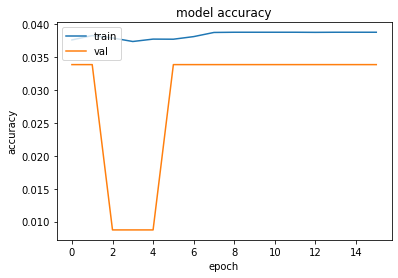

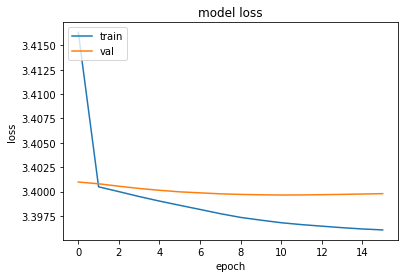

In [40]:
# Visualize training history
# source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# list all data in history
# print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
# # load history
# history_dict = json.load(open(your_history_path, 'r'))